In [48]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

import kagglehub
path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")
print("Path to dataset files:", path)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler

tfk = tf.keras              
tfkl = tf.keras.layers

Path to dataset files: /home/ursu/.cache/kagglehub/datasets/taweilo/loan-approval-classification-data/versions/1


In [24]:
data = pd.read_csv("loan_data.csv",delimiter=',')
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [50]:
df_model = data.copy()

y_data = df_model['loan_status'].values

# print(df_model.columns)

Features = ['person_age', 'person_gender', 'person_education', 'person_income',
           'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
           'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
           'credit_score', 'previous_loan_defaults_on_file']
X_df = df_model[Features]
X_df_encoded = pd.get_dummies(X_df, columns=['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file'], drop_first=True)
# print(X_df_encoded.head())
encoded_features_list = X_df_encoded.columns.tolist()


   person_age  person_income  person_emp_exp  loan_amnt  loan_int_rate  \
0        22.0        71948.0               0    35000.0          16.02   
1        21.0        12282.0               0     1000.0          11.14   
2        25.0        12438.0               3     5500.0          12.87   
3        23.0        79753.0               0    35000.0          15.23   
4        24.0        66135.0               1    35000.0          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561   
1                 0.08                         2.0           504   
2                 0.44                         3.0           635   
3                 0.44                         2.0           675   
4                 0.53                         4.0           586   

   person_gender_male  person_education_Bachelor  ...  \
0               False                      False  ...   
1               False           

In [27]:
scaler_x = RobustScaler()
x_features = scaler_x.fit_transform(X_df_encoded)

y_target = y_data


In [28]:
print(x_features.shape)
print(y_target.shape)

(45000, 22)
(45000,)


In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=45, stratify=y_target)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=45, stratify=y_train)

In [30]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(25200, 22)
(25200,)
(13500, 22)
(13500,)
(6300, 22)
(6300,)


In [43]:
from tensorflow.keras.layers import LeakyReLU

input_dim = x_features.shape[1]
model = tfk.Sequential([
    tfkl.InputLayer(shape=(input_dim,)),
    tfkl.Dense(256,LeakyReLU(negative_slope = 0.00001), name="Hidden_Layer_1"),
    tfkl.Dense(256,LeakyReLU(negative_slope = 0.00001), name="Hidden_Layer_2"),
    tfkl.Dense(1, activation='sigmoid', name="Output_Layer")
])

In [44]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

epochs = 350
batch_size = 16
opt = tfk.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(
    optimizer=opt, 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks = [early_stop]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 256)            │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,937 (281.00 KB)

 Trainable params: 71,937 (281.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 831us/step - accuracy: 0.7699 - loss: 0.5295 - val_accuracy: 0.8716 - val_loss: 0.3317
Epoch 2/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.8819 - loss: 0.3085 - val_accuracy: 0.8892 - val_loss: 0.2681
Epoch 3/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.8922 - loss: 0.2586 - val_accuracy: 0.8929 - val_loss: 0.2484
Epoch 4/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8971 - loss: 0.2338 - val_accuracy: 0.8962 - val_loss: 0.2377
Epoch 5/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9012 - loss: 0.2226 - val_accuracy: 0.8976 - val_loss: 0.2317
Epoch 6/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9015 - loss: 0.2233 - val_accuracy: 0.9006 - val_loss: 0.2264
Epoch 7/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.9040 - loss: 0.2151 - val_accuracy: 0.9022 - val_loss: 0.2233
Epoch 8/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 

Epoch 50/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.9228 - loss: 0.1726 - val_accuracy: 0.9116 - val_loss: 0.1981
Epoch 51/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - accuracy: 0.9243 - loss: 0.1744 - val_accuracy: 0.9116 - val_loss: 0.1980
Epoch 52/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9227 - loss: 0.1738 - val_accuracy: 0.9116 - val_loss: 0.1977
Epoch 53/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - accuracy: 0.9244 - loss: 0.1686 - val_accuracy: 0.9119 - val_loss: 0.1972
Epoch 54/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.9222 - loss: 0.1737 - val_accuracy: 0.9116 - val_loss: 0.1973
Epoch 55/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.9257 - loss: 0.1688 - val_accuracy: 0.9095 - val_loss: 0.1977
Epoch 56/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.9254 - loss: 0.1708 - val_accuracy: 0.9103 - val_loss: 0.1974
Epoch 57/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - ac

Epoch 99/350
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.9316 - loss: 0.1547 - val_accuracy: 0.9117 - val_loss: 0.1962


In [45]:
y_pred = model.predict(x_test)

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step


422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


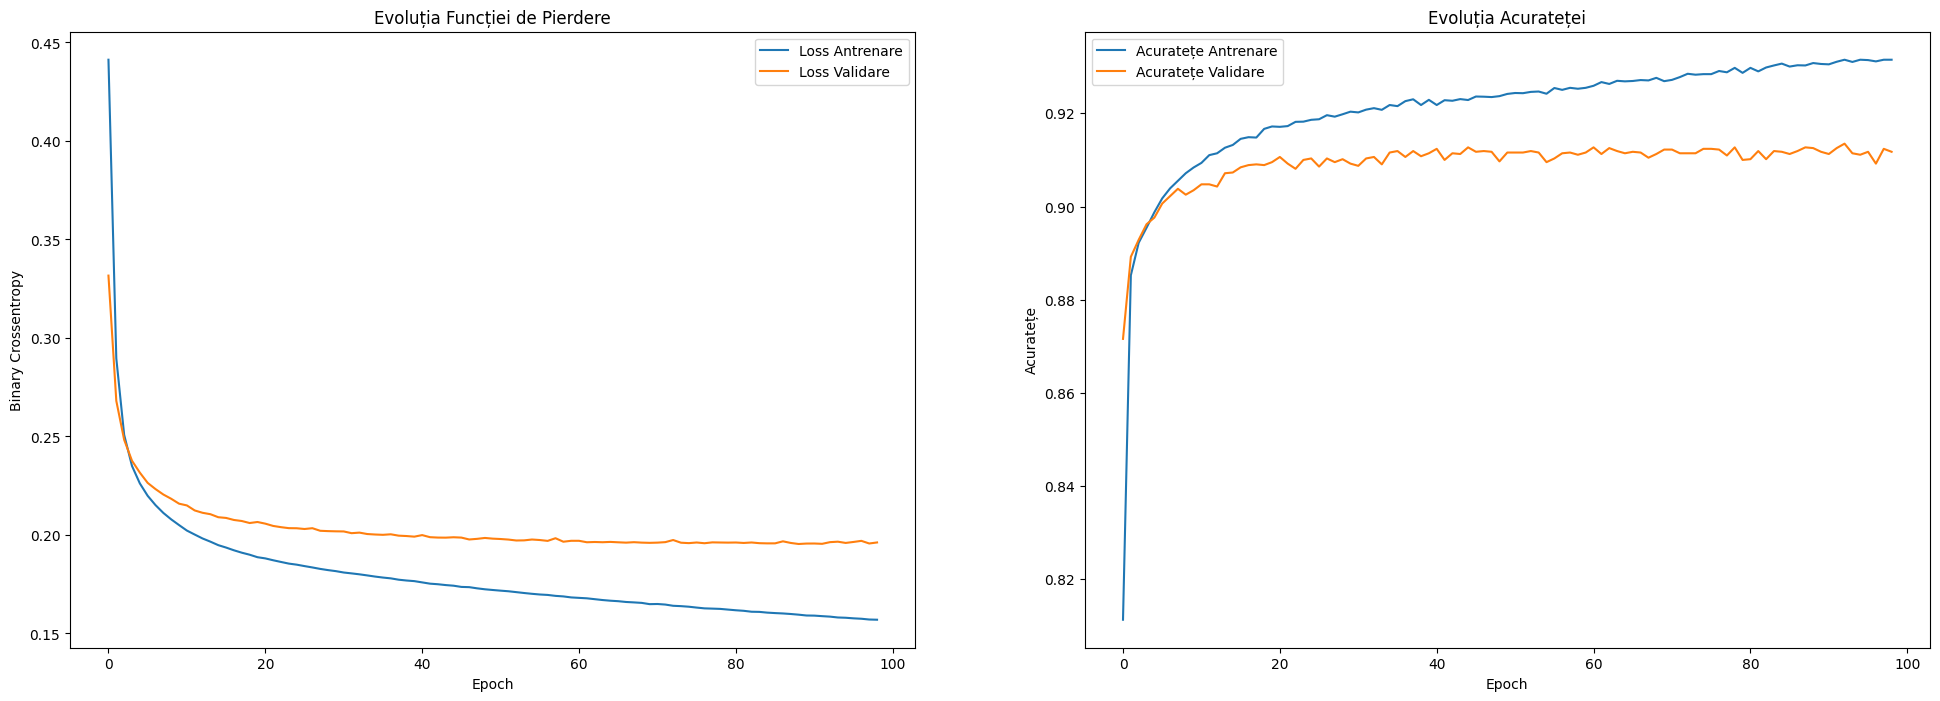


--- RAPORT DE PERFORMANȚĂ PE SETUL DE TEST ---

Acuratețea: 91.59%
Scorul AUC: 0.9659

Raport de Clasificare:
              precision    recall  f1-score   support

 Respins (0)       0.94      0.95      0.95     10500
Acceptat (1)       0.83      0.78      0.80      3000

    accuracy                           0.92     13500
   macro avg       0.88      0.87      0.88     13500
weighted avg       0.91      0.92      0.91     13500



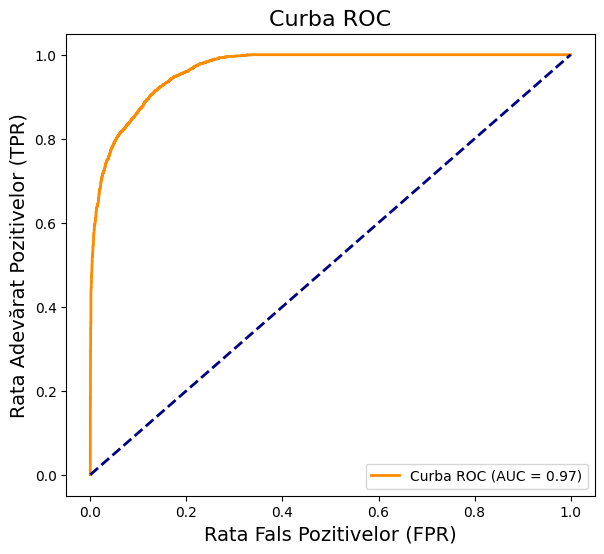

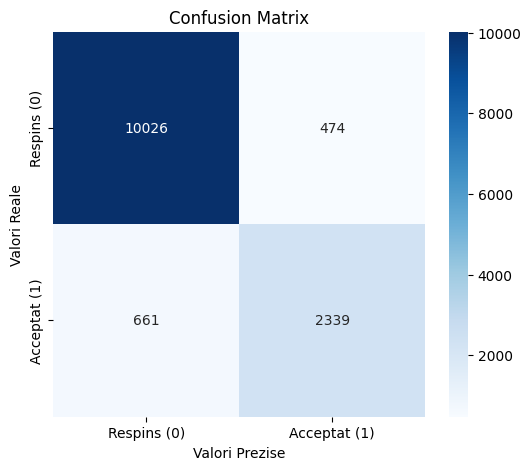

In [57]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

def evalueaza_model_clasificare(y_test, y_pred_proba, history):
    
    # --- Grafice de Antrenare ---
    plt.rcParams["figure.figsize"] = (24, 8)
    plt.figure()
    
    # Grafic pentru Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Loss Antrenare")
    plt.plot(history.history['val_loss'], label="Loss Validare")
    plt.title('Evoluția Funcției de Pierdere')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy')
    plt.legend()
    
    # Grafic pentru Acuratețe
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label="Acuratețe Antrenare")
    plt.plot(history.history['val_accuracy'], label="Acuratețe Validare")
    plt.title('Evoluția Acurateței')
    plt.xlabel('Epoch')
    plt.ylabel('Acuratețe')
    plt.legend()
    plt.show()

    # --- Evaluarea pe setul de test ---
    y_pred_clasa = (y_pred_proba > 0.5).astype(int)
    
    print("\n--- RAPORT DE PERFORMANȚĂ PE SETUL DE TEST ---\n")
    acuratete = accuracy_score(y_test, y_pred_clasa)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Acuratețea: {acuratete:.2%}")
    print(f"Scorul AUC: {auc:.4f}")
    
    print("\nRaport de Clasificare:")
    print(classification_report(y_test, y_pred_clasa, target_names=['Respins (0)', 'Acceptat (1)']))
    
    plt.rcParams["figure.figsize"] = (15, 6)
    plt.figure()

    # Curba ROC
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curba ROC (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Rata Fals Pozitivelor (FPR)', fontsize=14)
    plt.ylabel('Rata Adevărat Pozitivelor (TPR)', fontsize=14)
    plt.title('Curba ROC', fontsize=16)
    plt.legend(loc="lower right")
#     plt.show()
    
    cm = confusion_matrix(y_test, y_pred_clasa)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Respins (0)', 'Acceptat (1)'],
                yticklabels=['Respins (0)', 'Acceptat (1)'])
    plt.xlabel('Valori Prezise')
    plt.ylabel('Valori Reale')
    plt.title('Confusion Matrix')
    plt.show()


# Mai întâi, facem predicțiile pe setul de test
y_pred_proba = model.predict(x_test)

# Apoi, apelăm funcția de evaluare
evalueaza_model_clasificare(y_test, y_pred_proba, history)